## Imports

In [10]:
import torch
from torch import nn
import torch.nn.functional as F

import numpy as np
import networkx as nx

from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import remove_isolated_nodes, to_networkx

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from Graph_Nets import GCNetwork, GANetwork

### Dataset

In [11]:
dataset = Planetoid(root=".", name="CiteSeer")
data = dataset[0]

print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the Dataset
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: CiteSeer()
-------------------
Number of graphs: 1
Number of nodes: 3327
Number of features: 3703
Number of classes: 6

Graph:
------
Edges are directed: False
Graph has isolated nodes: True
Graph has loops: False


In [12]:
isolated = (remove_isolated_nodes(data['edge_index'])[2] == False).sum(dim=0).item()
print(f'Number of isolated nodes = {isolated}')

Number of isolated nodes = 48


In [13]:
print(data)

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])


In [14]:
g = to_networkx(data)
order = sorted(list(g.nodes()))
A = nx.adjacency_matrix(g, nodelist=order)
A = A.todense()
I = np.eye(A.shape[0])
A = A + I

In [15]:
X, y, A = torch.Tensor(data.x), torch.Tensor(data.y), torch.Tensor(A)

In [16]:
X.shape, y.shape, A.shape

(torch.Size([3327, 3703]), torch.Size([3327]), torch.Size([3327, 3327]))

## Training

In [8]:
in_features = data.x.size(1)
out_features = 100
n_classes = dataset.num_classes
num_heads = 4
bias = True
alpha = 0.2

#### Graph Convolutional Network

In [75]:
GCN = GCNetwork(in_features=in_features, 
                out_features=out_features, 
                n_classes=n_classes, 
                bias=bias)

In [76]:
num_epochs = 10
lr_rate=0.01

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(GCN.parameters(), lr=lr_rate)

In [77]:
a, b = GCN(X, A)
a.shape, b.shape

(torch.Size([3327, 100]), torch.Size([3327, 6]))

In [78]:
for epoch in range(num_epochs):
    GCN.train()
    _, preds = GCN(X, A)
    loss = loss_fn(preds[data.train_mask], data.y[data.train_mask])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    acc = float((torch.argmax(F.softmax(preds[data.train_mask], dim=1), axis=1) == data.y[data.train_mask]).sum() / data.y[data.train_mask].shape[0])

    val_loss = loss_fn(preds[data.val_mask], data.y[data.val_mask])
    val_acc = float((torch.argmax(F.softmax(preds[data.val_mask], dim=1), axis=1) == data.y[data.val_mask]).sum() / data.y[data.val_mask].shape[0])

    print(f'Epoch: {epoch+1} | train loss: {loss.item():.3f} | train accuracy: {acc:.3f} | val loss: {val_loss.item():.3f} | val accuracy {val_acc:.3f}')

Epoch: 1 | train loss: 1.794 | train accuracy: 0.158 | val loss: 1.804 | val accuracy 0.056
Epoch: 2 | train loss: 1.246 | train accuracy: 0.992 | val loss: 1.630 | val accuracy 0.636
Epoch: 3 | train loss: 0.742 | train accuracy: 0.992 | val loss: 1.455 | val accuracy 0.668
Epoch: 4 | train loss: 0.370 | train accuracy: 1.000 | val loss: 1.295 | val accuracy 0.676
Epoch: 5 | train loss: 0.160 | train accuracy: 1.000 | val loss: 1.178 | val accuracy 0.664
Epoch: 6 | train loss: 0.065 | train accuracy: 1.000 | val loss: 1.115 | val accuracy 0.650
Epoch: 7 | train loss: 0.026 | train accuracy: 1.000 | val loss: 1.098 | val accuracy 0.644
Epoch: 8 | train loss: 0.011 | train accuracy: 1.000 | val loss: 1.113 | val accuracy 0.634
Epoch: 9 | train loss: 0.005 | train accuracy: 1.000 | val loss: 1.147 | val accuracy 0.624
Epoch: 10 | train loss: 0.002 | train accuracy: 1.000 | val loss: 1.192 | val accuracy 0.614


#### Graph Attantion Network

In [79]:
GAN = GANetwork(in_features=in_features, 
                out_features=out_features, 
                n_classes=n_classes, 
                num_heads=num_heads, 
                alpha=alpha, 
                bias=bias)

In [80]:
num_epochs = 10
lr_rate=0.001

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(GAN.parameters(), lr=lr_rate)

In [81]:
X, A = X.unsqueeze(axis=0), A.unsqueeze(axis=0)

In [83]:
for epoch in range(num_epochs):
    _, preds = GAN(X, A)
    loss = loss_fn(preds.squeeze(axis=0)[data.train_mask], data.y[data.train_mask])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    acc = float((torch.argmax(F.softmax(preds.squeeze(axis=0)[data.train_mask], dim=1), axis=1) == data.y[data.train_mask]).sum() / data.y[data.train_mask].shape[0])

    val_loss = loss_fn(preds.squeeze(axis=0)[data.val_mask], data.y[data.val_mask])
    val_acc = float((torch.argmax(F.softmax(preds.squeeze(axis=0)[data.val_mask], dim=1), axis=1) == data.y[data.val_mask]).sum() / data.y[data.val_mask].shape[0])

    print(f'Epoch: {epoch+1} | train loss: {loss.item():.3f} | train accuracy: {acc:.3f} | val loss: {val_loss.item():.3f} | val accuracy {val_acc:.3f}')

Epoch: 1 | train loss: 1.793 | train accuracy: 0.192 | val loss: 1.806 | val accuracy 0.116
Epoch: 2 | train loss: 1.747 | train accuracy: 0.733 | val loss: 1.780 | val accuracy 0.238
Epoch: 3 | train loss: 1.687 | train accuracy: 0.958 | val loss: 1.750 | val accuracy 0.662
Epoch: 4 | train loss: 1.601 | train accuracy: 0.933 | val loss: 1.711 | val accuracy 0.690
Epoch: 5 | train loss: 1.486 | train accuracy: 0.925 | val loss: 1.659 | val accuracy 0.684
Epoch: 6 | train loss: 1.340 | train accuracy: 0.925 | val loss: 1.593 | val accuracy 0.682
Epoch: 7 | train loss: 1.164 | train accuracy: 0.933 | val loss: 1.514 | val accuracy 0.682
Epoch: 8 | train loss: 0.965 | train accuracy: 0.942 | val loss: 1.422 | val accuracy 0.686
Epoch: 9 | train loss: 0.760 | train accuracy: 0.942 | val loss: 1.321 | val accuracy 0.700
Epoch: 10 | train loss: 0.565 | train accuracy: 0.942 | val loss: 1.218 | val accuracy 0.702


In [75]:
from sklearn.manifold import TSNE

In [102]:
(h1, _), (h2, _) = GCN(X.squeeze(axis=0), A.squeeze(axis=0)), GAN(X, A)

tsne1 = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(h1.squeeze(axis=0).detach())
tsne2 = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(h2.squeeze(axis=0).detach())

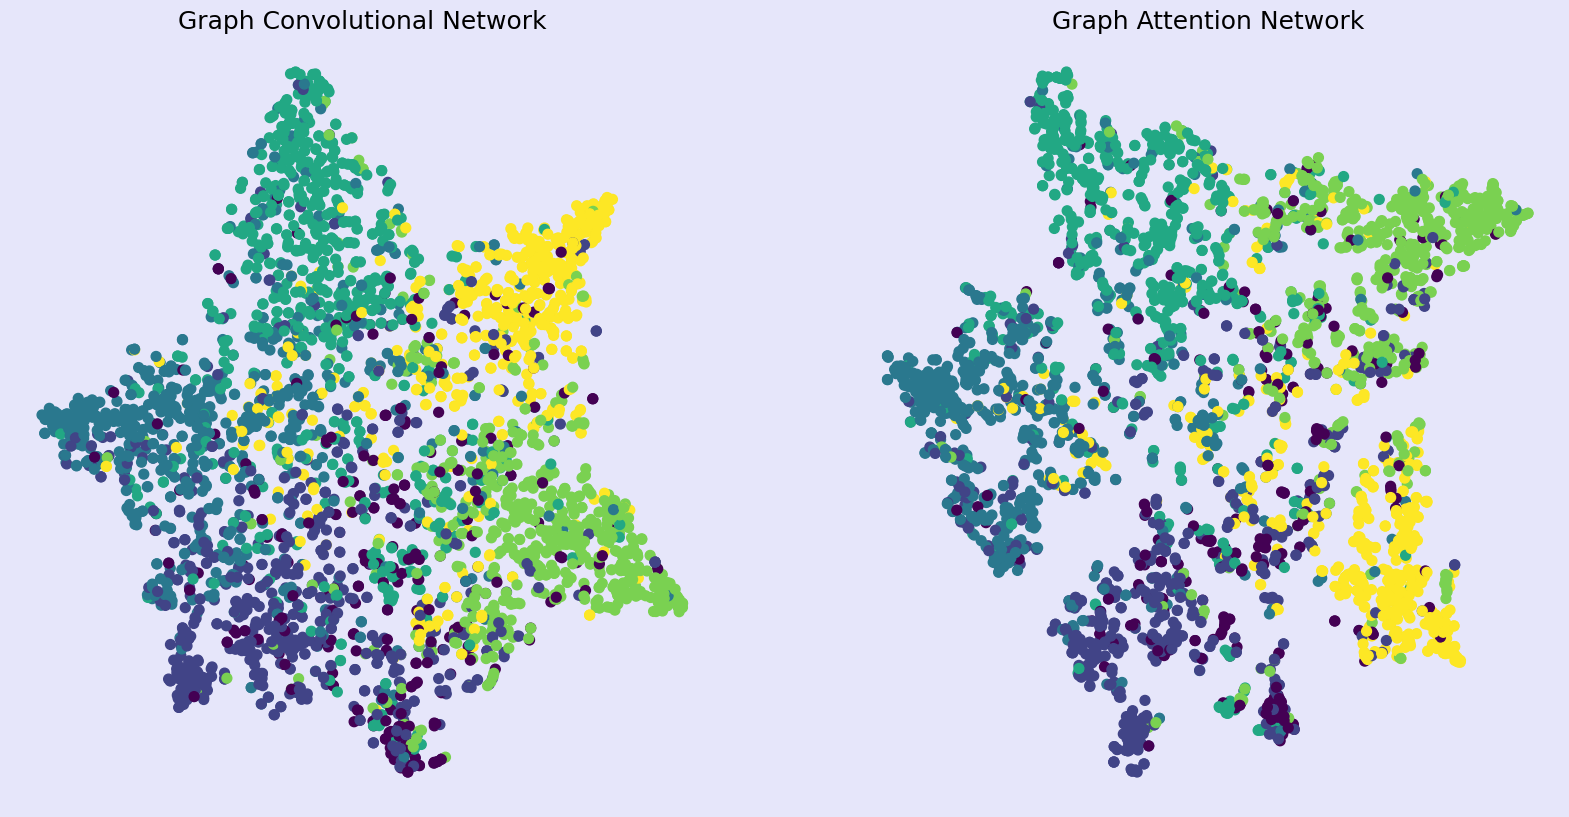

In [126]:
fig, ax = plt.subplots(1,2, figsize=(20, 10), facecolor='lavender')

ax[0].set_title("Graph Convolutional Network", size=18)
ax[0].scatter(tsne1[:, 0], tsne1[:, 1], s=50, c=data.y)
ax[0].axis('off')

ax[1].set_title("Graph Attention Network",  size=18)
ax[1].scatter(tsne2[:, 0], tsne2[:, 1], s=50, c=data.y)
ax[1].axis('off');

In [124]:
torch.save(GCN.state_dict(), 'weights/GCN.pt')
torch.save(GAN.state_dict(), 'weights/GAN.pt')

In [50]:
class GCNetwork(nn.Module):
    def __init__(self, 
                 in_features, 
                 out_features, 
                 n_classes, 
                 bias=True, 
                 num_layers=1):
        super().__init__()
        """
        in_features :   number of columns in input matrix X,
        out_features:   desired number of embedding/output variables,
        n_classes   :   number of target classes,
        bias        :   whether linear layers should have bias term or not,
        num_layers  :   if num_layers=2 information of neighbor's neighbors will be aggregated in a edges too
        """
        self.num_layers = num_layers
        self.W1 = nn.Linear(in_features, out_features, bias=bias)
        if num_layers==2:
            self.W2 = nn.Linear(out_features, out_features, bias=bias)
        self.FL = nn.Linear(out_features, n_classes)

    def block(self, x, A_tilda, W):
        """
        --input
        x       : feature matrix size of (m, n) where m is number of edges and n is number of features,
        A_tilda : regularization term which scales values of new embeddings based on number of connections,
        W       : linear layer on to project input x
        --output
        x       : features matrix with size (number_of_edges, out_features) or simply new embedding matrix
        """
        x = A_tilda @ x
        x = W(x)
        x = F.relu(x)
        return x
    
    def forward(self, x, A):
        """
        --inputgit 
        x : feature matrix size of (m, n) where m is number of edges and n is number of features,
        A : adjacency matrix with size (m, m) which captures connections between edges
        --output
        x   : last features space with size of (m, out_features)
        out : logits (without softmax) with size of (m, n_classes)
        """
        A_tilda = torch.diag(torch.rsqrt(A.sum(axis=0))) @ A @ torch.diag(torch.rsqrt(A.sum(axis=0))) # (number_of_edges, number_of_edges)
        x = self.block(x, A_tilda, self.W1) # (number_of_edges, out_features)
        if self.num_layers==2:
            x = self.block(x, A_tilda, self.W2) # (number_of_edges, out_features)
        out = self.FL(x) # (number_of_edges, n_classes)

        return x, out

In [26]:
W1 = nn.Linear(in_features, out_features, bias=bias)
FL = nn.Linear(out_features, n_classes)

In [27]:
A_tilda = torch.diag(torch.rsqrt(A.sum(axis=0))) @ A @ torch.diag(torch.rsqrt(A.sum(axis=0)))

In [38]:
(A_tilda @ F.relu(W1(A_tilda @ X))).shape

torch.Size([3327, 100])

In [51]:
k = GCNetwork(in_features=in_features, out_features=out_features, n_classes=n_classes, bias=True, num_layers=2)

In [17]:
G = GCNetwork(in_features=in_features, out_features=out_features, n_classes=n_classes, bias=True, num_layers=1)

In [21]:
a, b= G(X, A)
a.shape, b.shape

(torch.Size([3327, 100]), torch.Size([3327, 6]))